In [1]:
import findspark
findspark.init() 

import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *



In [2]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")


In [3]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["Temperature(F)", "Wind_Speed(mph)", "Humidity(%)"], outputCols=["Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed"])
df = imputer.fit(df).transform(df)

df = df.dropna(subset=["Severity"])

In [4]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import numpy as np

kmeans_features = ["Start_Lat", "Start_Lng"]
assembler = VectorAssembler(inputCols=kmeans_features, outputCol="features")
df_kmeans = assembler.transform(df)


kmeans = KMeans(featuresCol="features", k=5, seed=1)  
kmeans_model = kmeans.fit(df_kmeans)
df_kmeans = kmeans_model.transform(df_kmeans) 

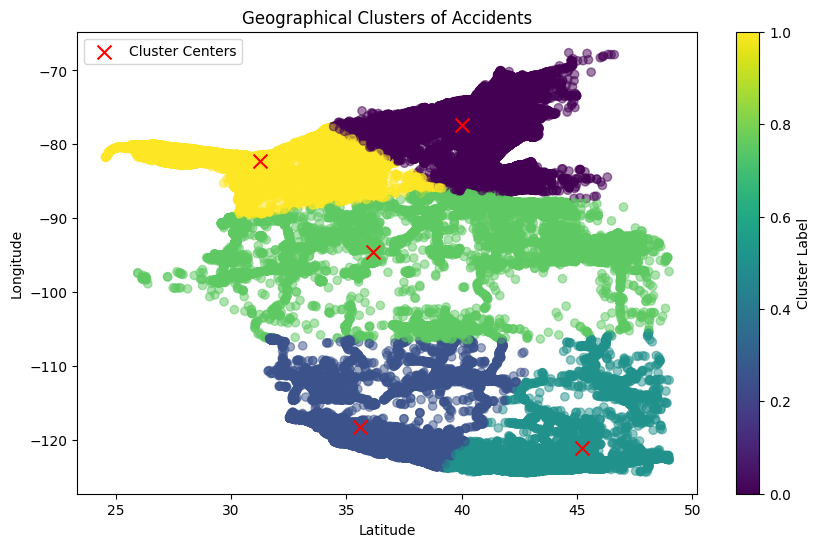

In [6]:
# Sample 5% of data
df_sampled = df_kmeans.sample(fraction=0.05, seed=42)
df_pd = df_sampled.select("Start_Lat", "Start_Lng", "prediction").toPandas()

cluster_centers = np.array(kmeans_model.clusterCenters())
cluster_labels = df_pd['prediction'].values

plt.figure(figsize=(10, 6))
plt.scatter(df_pd['Start_Lat'], df_pd['Start_Lng'], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='red', s=100, label="Cluster Centers")
plt.colorbar(label='Cluster Label')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Geographical Clusters of Accidents')
plt.legend()
plt.show()


In [7]:
accidents_per_cluster = df_pd['prediction'].value_counts().sort_index()

print("Accident counts per cluster:")
print(accidents_per_cluster)

mean_locations = df_pd.groupby('prediction')[['Start_Lat', 'Start_Lng']].mean()
print("\nMean Location (Lat, Lng) per cluster:")
print(mean_locations)


Accident counts per cluster:
prediction
0     96276
1    101762
2     18101
3     75822
4     94755
Name: count, dtype: int64

Mean Location (Lat, Lng) per cluster:
            Start_Lat   Start_Lng
prediction                       
0           40.018518  -77.347106
1           35.614972 -118.260698
2           45.232670 -121.109024
3           36.171578  -94.514180
4           31.277764  -82.316586


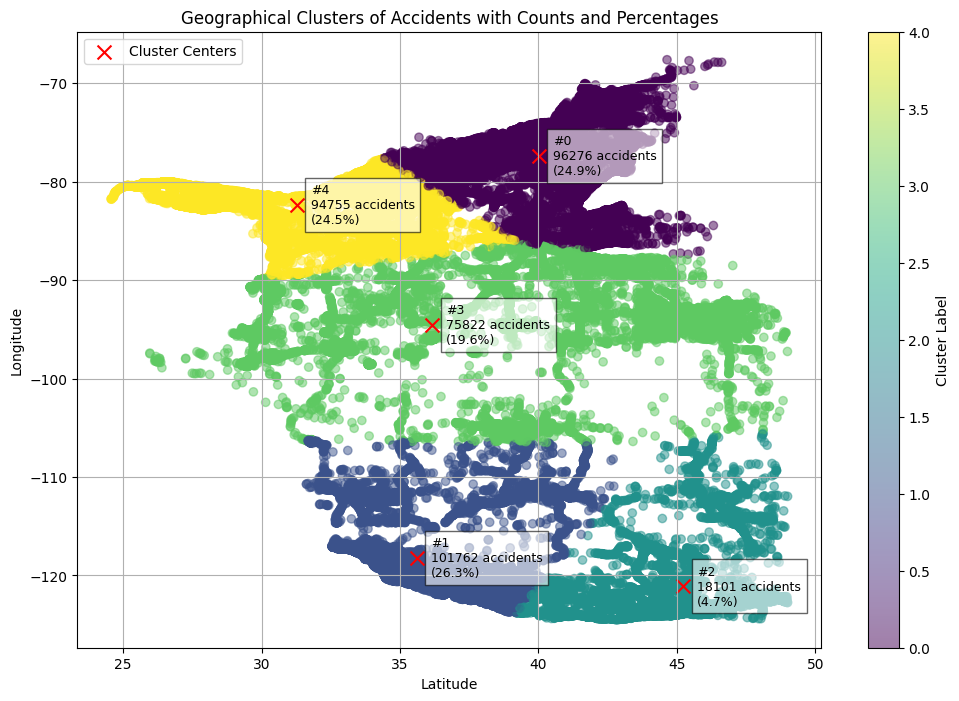

In [8]:
import matplotlib.pyplot as plt
import numpy as np

cluster_counts = [96276, 101762, 18101, 75822, 94755]
cluster_centers = np.array([
    [40.018518, -77.347106],
    [35.614972, -118.260698],
    [45.232670, -121.109024],
    [36.171578, -94.514180],
    [31.277764, -82.316586]
])
total_accidents = sum(cluster_counts)
percentages = [count / total_accidents * 100 for count in cluster_counts]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_pd['Start_Lat'], df_pd['Start_Lng'], c=df_pd['prediction'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster Label')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='red', s=100, label="Cluster Centers")

for i, (x, y) in enumerate(cluster_centers):
    plt.text(x + 0.5, y, f"#{i}\n{cluster_counts[i]} accidents\n({percentages[i]:.1f}%)",
             fontsize=9, color='black', ha='left', va='center', bbox=dict(facecolor='white', alpha=0.6))

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Geographical Clusters of Accidents with Counts and Percentages')
plt.legend()
plt.grid(True)
plt.show()
